In [1]:
# !pip install pycocotools
# !pip install bresenham

In [2]:
import copy
from pathlib import Path
import cv2
import json
import numpy as np
import matplotlib.pyplot as plt

import pycocotools.mask as mask_util

from bresenham import bresenham

GLOB_IMG = "*[.png|.PNG][.jpg|.JPG]"

### Helper Functions

In [3]:
def padd_square(img, desired_size, padd_color=255):
    """
        resize and square padd
        img: np.array of image shaped (h,w,c)
        desired_size: int size of the image after resize and padding
    """
    
    if padd_color==255 and img.ndim == 3:
        padd_color = [255, 255, 255]
    
    size = img.shape[:2]
    delta_w = desired_size - size[1]
    delta_h = desired_size - size[0]
    top, bottom = delta_h//2, delta_h-(delta_h//2)
    left, right = delta_w//2, delta_w-(delta_w//2)

    new_img = cv2.copyMakeBorder(img, top, bottom, left, right, cv2.BORDER_CONSTANT,
    value=padd_color)

    return new_img, (left, top)


def resize(image, width=None, height=None, inter=cv2.INTER_AREA):
    # (Borrowed from imutils)initialize the dimensions of the image to be resized and
    # grab the image size
    dim = None
    (h, w) = image.shape[:2]

    # if both the width and height are None, then return the
    # original image
    if width is None and height is None:
        return image

    # check to see if the width is None
    if width is None:
        # calculate the ratio of the height and construct the
        # dimensions
        r = height / float(h)
        dim = (int(w * r), height)

    # otherwise, the height is None
    else:
        # calculate the ratio of the width and construct the
        # dimensions
        r = width / float(w)
        dim = (width, int(h * r))

    # resize the image
    resized = cv2.resize(image, dim, interpolation=inter)

    # return the resized image
    return resized


def resize_image(img, max_size=512, padd=True):
    """
        img: rgb image of line chart
        max_size: resize max dimension of input to this size (maintaining aspect ratio)
        padd: whether to square padd the image after resizing
        returns: rgb image of resized line chart
    """

    clean_img = img
    tx_crop, ty_crop = 0,0
    sx, sy= 1,1
    tx_padd, ty_padd = 0,0

    h_cropped, w_cropped = clean_img.shape[:2]
    if max_size:
        if clean_img.shape[0] > clean_img.shape[1]:
            clean_img = resize(clean_img, height=max_size)
        else:
            clean_img = resize(clean_img, width=max_size)
        
        sx, sy = float(clean_img.shape[1])/w_cropped, float(clean_img.shape[0])/h_cropped

    if padd:
        clean_img, (tx_padd, ty_padd) = padd_square(clean_img, max_size)

    transformation = (sx, sy, tx_crop, ty_crop, tx_padd, ty_padd)
    
    return clean_img, transformation


In [4]:
def get_lines(ln_data):
    pt = []
    ipt = []
    for ln in ln_data :
        ptl = [] 
        iptl = [] 
        for ix, pt_ in enumerate(ln) :
            px= pt_['x']; py =pt_['y']
            ptl.append(list((px, py)))
            if ix > 0 : 
                ppx, ppy = ln[ix-1]['x'],  ln[ix-1]['y']
                # iptl.append(interpolt(ppx, ppy, px, py, all_=True))
                iptl.append(bresenham(ppx, ppy, px, py))
        pt.append(ptl)
        ipt.append(iptl)
    return pt, ipt

def get_inst_masks_bin(img_h, img_w, ln_data, thickness=1):
    """
        Returns - 
            all_inst_masks: list of binary masks, one for each line
    """
    # ln_name = [ln['name'] for ln in js_obj['task6']['output']['data series']]
    
    all_points, all_ipoints= get_lines(ln_data)
    all_inst_masks = []

    point_list = []
    for l_idx, l_ in enumerate(all_ipoints) :
        pl = []
        l_all_pts = [pt for pt_set in l_ for pt in pt_set]
        inst_mask = np.zeros((img_w, img_h))
        for (x,y) in l_all_pts :
            x = min(max(0, x), img_w-1)
            y = min(max(0, y), img_h-1)
            pl.append((x, y))
            inst_mask[int(x), int(y)]=1
        point_list.append(pl)

        # If making lines thicker, do it for every line individually..
        if thickness > 1:
            inst_mask = cv2.dilate(inst_mask, cv2.getStructuringElement(cv2.MORPH_RECT, (thickness, thickness)))
        
        all_inst_masks.append(inst_mask.T)

    return all_inst_masks

def transform_line_data(lines_data, transformation):
    lines_data = copy.deepcopy(lines_data)
    
    (sx, sy, tx_crop, ty_crop, tx_padd, ty_padd) = transformation

    def _transform_x(x):
        return int((x-tx_crop)*sx + tx_padd)

    def _transform_y(y):
        return int((y-ty_crop)*sy + ty_padd)
    
    for ln in lines_data:        
        # transform line points
        for pt in ln:
            pt['x'] = _transform_x(pt['x']); pt['y'] = _transform_y(pt['y'])
    
    return lines_data

### COCO Format Converter

In [5]:
def single_image_coco_annot(sample_idx, img_path, lines_point_data, save_img_path, line_thickness):
    img = cv2.cvtColor(cv2.imread(str(img_path)), cv2.COLOR_BGR2RGB)

    try:
        # resize the image to 512x512 keeping the same aspect ratio by padding symmetrically the shorter image side
        clean_img, transformation = resize_image(img, max_size=512, padd=True)
        h,w = clean_img.shape[:2]

        # to reflect the change in x,y values for line points due to image resize in previous step 
        lines_point_data = transform_line_data(lines_point_data, transformation)
        
        # get line only instance masks
        line_masks = get_inst_masks_bin(h, w, lines_point_data, line_thickness)

        # save clean_image
        if save_img_path:
            cv2.imwrite(str(save_img_path), clean_img)

    except:
        print(f'Error for: {img_path}')
        # return [], {}
        raise

    img_info = dict(id=sample_idx, file_name=img_path.name.replace(".jpg", ".png"), height=h, width=w)
    annot = []
    for m_idx, mask in enumerate(line_masks):
        segment_mask = mask > 0
        rle_mask = mask_util.encode(np.array(segment_mask[:, :, np.newaxis], order='F', dtype='uint8'))[0]
        rle_mask['counts'] = rle_mask['counts'].decode()
        annot.append({'image_id': img_info['id'], 'category_id': 1, 'iscrowd': 0,
                    "bbox": [1,2,3,4], "area": 10, # CAUTION: BBOX are not used for LineFormer/Mask2Former, but these values have to be non-zero, otherwise MMDetection's CocoDataset loader to work properly!!
                'segmentation': rle_mask})

    return (img_info, annot)


def generate_coco_inst_annot(annot_dir, img_dir, target_img_dir, pt_annot_parser, categories, line_thickness):
    
    img_path = {img_path.stem: img_path for img_path in Path(img_dir).glob(GLOB_IMG)}
    annot_path = {annot_path.stem: annot_path for annot_path in Path(annot_dir).glob("*.json")}
    sample_names = sorted(list(set(img_path.keys()).intersection(set(annot_path.keys()))))

    annotations = []
    images = []
    
    # Returns data in the form [[{'x': <x-coordinate of line point on image>, 'y': <y-coordinate of line point on image>}, ...]]
    # each sublist represents points belonging to a single line
    # pixel-wise line masks are generated by interpolating between the annotated line points (using the bresenham algorithm)

    for idx, sample in enumerate(sample_names):
        with open(annot_path[sample], 'r') as f:
            annot = json.load(f)
    
        lines_point_data = pt_annot_parser(annot)

        save_img_path = None if not target_img_dir else target_img_dir+f"/{sample}.png"
        img_info, annot_info = single_image_coco_annot(idx, img_path = img_path[sample],
                                                        lines_point_data=lines_point_data,
                                                        save_img_path=save_img_path,
                                                        line_thickness=line_thickness)
        images.append(img_info)
        annotations.extend(annot_info)

    # update id for each annotation/instance
    for idx, annot in enumerate(annotations):
        annot['id'] = idx+1

    return dict(images=images, annotations=annotations, categories=categories)

In [6]:
def parse_line_data_pmc(annot):
    # mapping between visual elements to legend labels
    data_series = annot['task6']['output']['data series']
    visual_elements = annot['task6']['output']['visual elements']['lines']
    label2dataidx = {item['name']: idx for idx, item in enumerate(data_series)}
    label2visual_elem = {label:visual_elements[idx] for label,idx in label2dataidx.items()}

    lines_data = [ln_data for label, ln_data in label2visual_elem.items()]
    
    return lines_data

### Perform Conversion

In [7]:
# annot_dir = '/data_local/jayashok/pmc_data_2022/train_json_pmc'
annot_dir = 'sample_annot/'

# img_dir = '/data_local/jayashok/pmc_data_2022/train_images'
img_dir = 'sample_imgs/'

# target_img_dir = '/data_local/jayashok/coco_pmc_deg/train_images/'
target_img_dir = 'resized_imgs/'

coco_annot_save_path = "sample_coco_annot.json"

In [8]:
categories = [{'supercategory': 'foreground',
  'color': [220, 20, 60],
  'isthing': 1,
  'id': 1,
  'name': 'line'}
]

In [9]:
annot_dir, img_dir

('sample_annot/', 'sample_imgs/')

In [10]:
coco_annot = generate_coco_inst_annot(annot_dir, img_dir,
                                    target_img_dir=target_img_dir,
                                    pt_annot_parser=parse_line_data_pmc,
                                    categories=categories, line_thickness=3)

In [13]:
with open(coco_annot_save_path, 'w') as f:
    json.dump(coco_annot, f)

### Verify COCO Mask Annotations

In [15]:
import random, os
import pandas as pd

In [16]:
sample = random.choice(os.listdir(annot_dir)).rstrip(".json")
sample

'PMC1090595___1471-2458-5-36-1'

In [17]:
df = pd.DataFrame(coco_annot['images']).query(f"file_name == '{sample}.png'")
print(df)

   id                          file_name  height  width
0   0  PMC1090595___1471-2458-5-36-1.png     512    512


In [18]:
test_annot = list(filter(lambda annot_: annot_['image_id'] == df['id'].values[0], coco_annot['annotations']))

In [19]:
show_path = f"{target_img_dir}/{sample}.png"
show_path

'resized_imgs//PMC1090595___1471-2458-5-36-1.png'

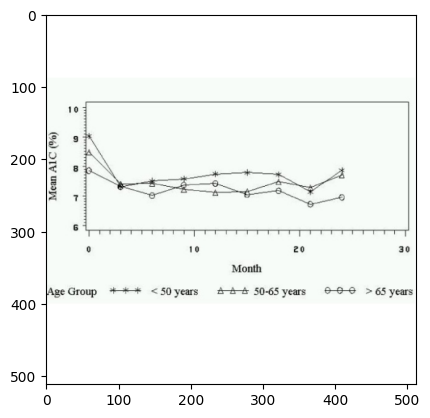

{'image_id': 0, 'category_id': 1, 'iscrowd': 0, 'bbox': [1, 2, 3, 4], 'area': 10, 'segmentation': {'size': [512, 512], 'counts': 'WUm03m?2N2O01000O01000O01000O01000O01000O0100O0100O01000O01000O01000O01000O01000O01000O01N2N00O1000O1000000000O1000O1000000000O1000O10000000O1000O1000000000O1000O1000000000O1000O100000000000O1000O1000000000000000O1000O100000000000000000O1000O1000000000000000O1000O100000000000O1000O10000000O1000O10000000O1000O10000000O1000O10000000O1000O10000000O1000O1000000000000000000000O1000O10000000000000000000000000000000000000O1000O100000000000000000000000000000000000000001O01O0000000000000000000000000000000000000001O01O00000000000000000001O010O010O010O10O10O010O010O10O10O010O010O10O10O010O010O010O10O10O010O010O10O10O010O010O000O0010O00010O00010O00010O00010O00010O0001O01O00010O00010O00010O00010O00010O00010O00100OZYb1'}, 'id': 1}


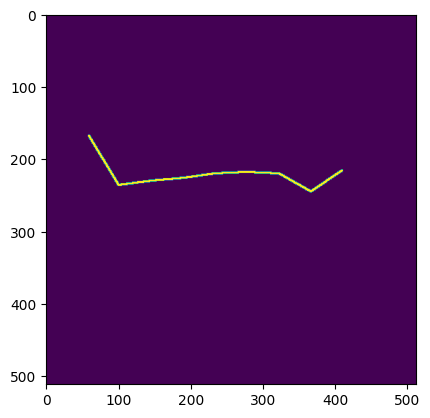

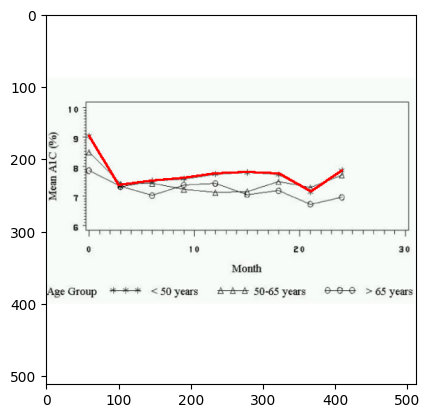

In [22]:
# Check the Image
plt.imshow(cv2.imread(show_path))
plt.show()

# Check the Mask
ann_idx = 0
print(test_annot[ann_idx])
plt.imshow(mask_util.decode(test_annot[ann_idx]['segmentation']))
plt.show()

# Check Image to Mask Alignment!
test_img = cv2.imread(show_path)
test_mask = mask_util.decode(coco_annot['annotations'][ann_idx]['segmentation'])
test_img[test_mask==1, :] = (255, 0, 0)
plt.imshow(test_img)
plt.show()